Umphrey's McGee (UM) is an American progressive rock band that plays many live shows and writes an original setlist for each of their shows, similar to the Grateful Dead. The goal of this project is to create an LSTM neural network (with Tensorflow and Keras) that can predict imaginary setlists from the band.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
import re
import tensorflow as tf
import sys

from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding

from keras.preprocessing.text import Tokenizer

from wordcloud import WordCloud, STOPWORDS

The website allthings.umphreys.com has every setlist organized by year, in URLs such as https://allthings.umphreys.com/setlists/2009. We create a list of urls for every year since the band started in 1998.

In [2]:
urls = ['https://allthings.umphreys.com/setlists/' + str(year) for year in range(1998,2023)]
urls

['https://allthings.umphreys.com/setlists/1998',
 'https://allthings.umphreys.com/setlists/1999',
 'https://allthings.umphreys.com/setlists/2000',
 'https://allthings.umphreys.com/setlists/2001',
 'https://allthings.umphreys.com/setlists/2002',
 'https://allthings.umphreys.com/setlists/2003',
 'https://allthings.umphreys.com/setlists/2004',
 'https://allthings.umphreys.com/setlists/2005',
 'https://allthings.umphreys.com/setlists/2006',
 'https://allthings.umphreys.com/setlists/2007',
 'https://allthings.umphreys.com/setlists/2008',
 'https://allthings.umphreys.com/setlists/2009',
 'https://allthings.umphreys.com/setlists/2010',
 'https://allthings.umphreys.com/setlists/2011',
 'https://allthings.umphreys.com/setlists/2012',
 'https://allthings.umphreys.com/setlists/2013',
 'https://allthings.umphreys.com/setlists/2014',
 'https://allthings.umphreys.com/setlists/2015',
 'https://allthings.umphreys.com/setlists/2016',
 'https://allthings.umphreys.com/setlists/2017',
 'https://allthings.

By inspecting the source code, we can observe that the text for each show's setlist is contained in an html class 'setlist setlist-container.'

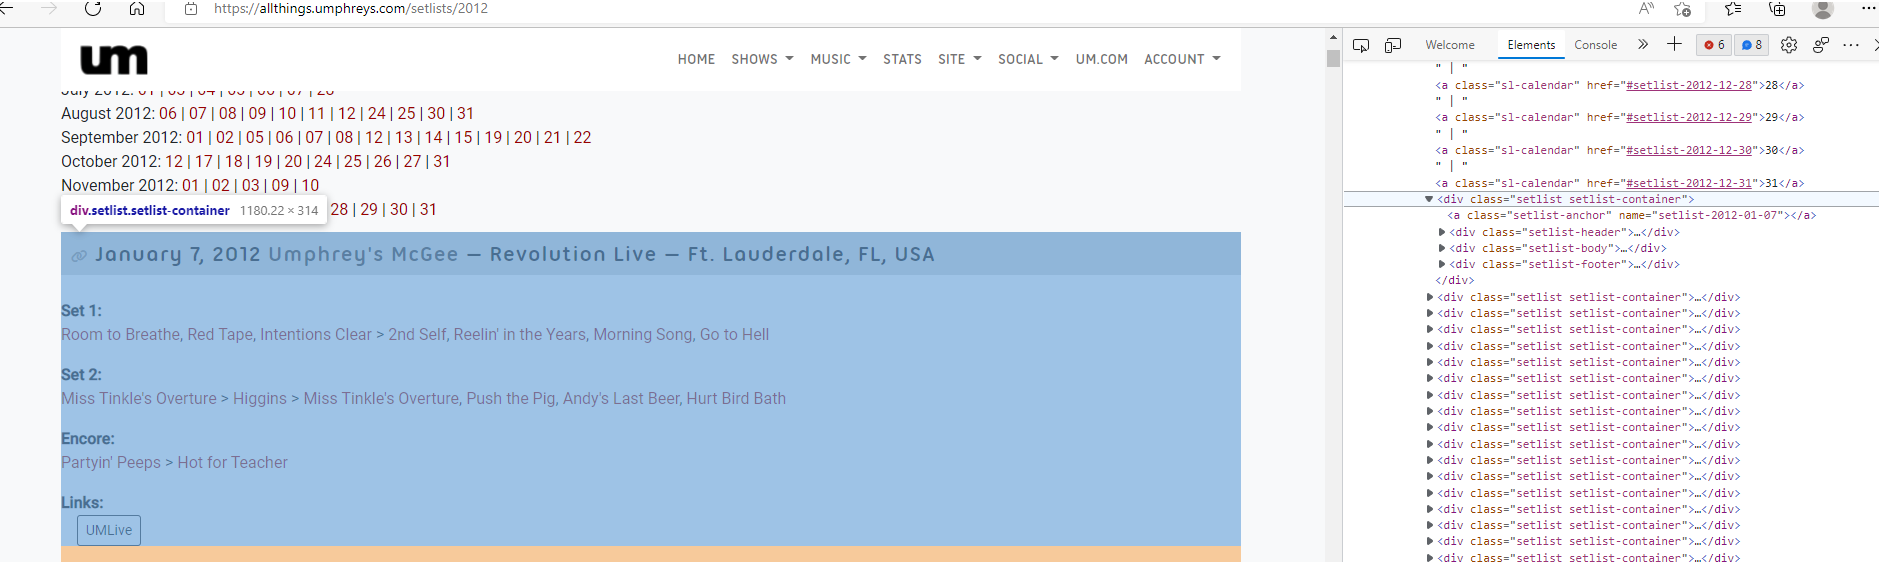

We use BeautifulSoup to scrape the text for the setlists for each show, for each year, and contain them in a list of strings. 

In [7]:
setlists = []

for url in urls:
    webpage = requests.get(url)
    soup = BeautifulSoup(webpage.content,'html.parser')
    matches = soup.find_all(class_='setlist setlist-container')
    for match in matches:
        setlists.append(match.get_text())
        
setlists_pretoken = np.array(setlists)

In [8]:
setlists_size = len(setlists_pretoken)
print(f'This list contains {setlists_size} setlists.')

This list contains 2603 setlists.


Here is an example of what an actual setlist looks like.

In [9]:
print(setlists_pretoken[1871])






 July 11, 2013
Umphrey's McGee —
				Indian Lookout Country Club — Mariaville, NY, USA "Camp Bisco" 
			


One Set: Wappy Sprayberry[1] >  Breathe[2],  The Triple Wide[3],  In The Kitchen[4],  Partyin' Peeps[4],  Home Again[5],  The Linear[6],  Booth Love[7] 


Footnotes:    [1] with David Murphy on bass    [2] with David Murphy on bass; dub version    [3] with David Murphy on bass; "Jimmy Stewart" with lyrics    [4] with Marc Brownstein on bass    [5] with Marc Brownstein on bass and vocals and Jon Gutwillig on guitar and vocals    [6] with Bryan Doherty on bass    [7] with Bryan Doherty on bass, and with Aron Magner joining Joel on keytars
Show Notes: entire show without Ryan
Main 1 Stage
last Home Again 2006-05-05 (837 shows)
Links:    UMLive




We use the Tokenizer library to tokenize each character in the corpus of setlists, then create training sequences of length (training_length) characters and assign each one a label of the following character.

In [45]:
training_length = 90

#create tokenizer object and train on all setlists
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(setlists)
    
#create and store dictionaries between words and indices
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word
num_words = len(word_idx) + 1
word_counts = tokenizer.word_counts

#When we pre-pad the tokenized sequences, we might get 0's so we assign those to the empty string
idx_word[0] = ''
word_idx[''] = 0
 
print(f'There are {num_words} unique characters.')

#convert each setlist to sequence of indices
sequences = tokenizer.texts_to_sequences(setlists)



#create training examples out of the sequences
features = []
labels = []

for seq in sequences:
    
    #pad any sequences that are shorter than the training length
    if len(seq) < training_length:
        
        seq = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=training_length).flatten()
    
    for i in range(training_length, len(seq)):
        #extract (training_length)+1 characters
        extract = seq[i-training_length:i+1]
        
        #the first (training_length) characters are the features, the following character after that is the label
        features.append(extract[:-1])
        labels.append(extract[-1])
        
print(f'There are {len(features)} training sequences.')

There are 84 unique characters.
There are 1316376 training sequences.


In [11]:
num_epochs = 5
num_batches = 64

Our model requests a batch size in advance, so we cut off the remainder of the sequences so that the size of the input is a multiple of the batch size.

In [12]:
num_sequences = len(features)
cutoff = (num_sequences//num_batches)*num_batches

features = np.array(features[:cutoff])
labels = np.array(labels[:cutoff])

We define our LSTM model by making a function so that we can change the batch size later when we need to make predictions.

In [16]:
def lstm_model(batch_size):
    model = tf.keras.models.Sequential()
    model.add(Embedding(num_words, output_dim=256, input_length=training_length,     batch_input_shape = [batch_size, None]))
    model.add(Bidirectional(LSTM(256,input_shape=(training_length,1),return_sequences=True,stateful=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(128,return_sequences=False,stateful=True))
    model.add(Dropout(0.5))
    model.add(Dense(num_words,activation='softmax'))
    return model

In [17]:
model = lstm_model(batch_size=num_batches)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           21504     
                                                                 
 bidirectional (Bidirectiona  (64, None, 512)          1050624   
 l)                                                              
                                                                 
 dropout (Dropout)           (64, None, 512)           0         
                                                                 
 lstm_1 (LSTM)               (64, 128)                 328192    
                                                                 
 dropout_1 (Dropout)         (64, 128)                 0         
                                                                 
 dense (Dense)               (64, 84)                  10836     
                                                        

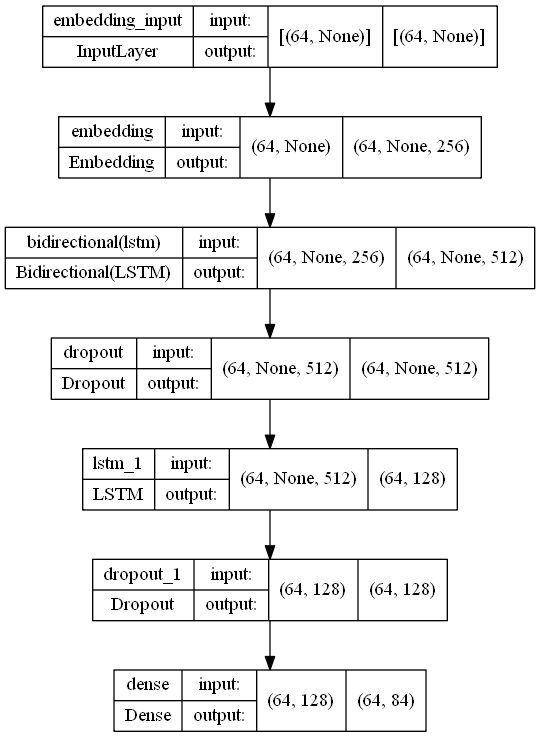

In [19]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
history = model.fit(features, labels, epochs=num_epochs, batch_size=num_batches)

Epoch 1/5
14110/14110 [==============================] - 2969s 209ms/step - loss: 1.4534 - accuracy: 0.5909
Epoch 2/5
14110/14110 [==============================] - 2120s 150ms/step - loss: 0.9958 - accuracy: 0.7107
Epoch 3/5
14110/14110 [==============================] - 2065s 146ms/step - loss: 0.9088 - accuracy: 0.7325
Epoch 4/5
14110/14110 [==============================] - 2062s 146ms/step - loss: 0.8706 - accuracy: 0.7422
Epoch 5/5
14110/14110 [==============================] - 2062s 146ms/step - loss: 0.8515 - accuracy: 0.7465


In [ ]:
model.save_weights(f'UM_weights_{training_length}_chars')

In [20]:
history.history

{'loss': [1.453431487083435,
  0.9958110451698303,
  0.9087520837783813,
  0.8705847859382629,
  0.8514686226844788],
 'accuracy': [0.5908553600311279,
  0.7106894254684448,
  0.7324526309967041,
  0.742238461971283,
  0.7464541792869568]}

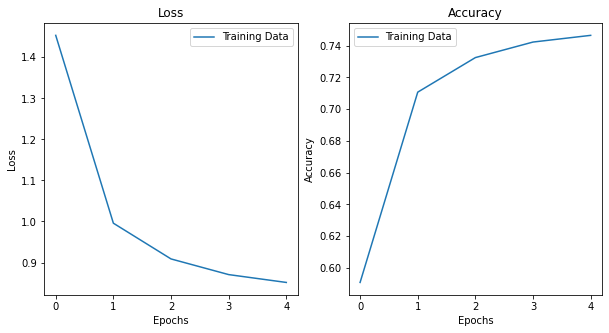

In [21]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(range(len(history.history['loss'])),history.history['loss'])

#plt.subplot(1,2,1)
#plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Data'])
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(range(len(history.history['accuracy'])),history.history['accuracy'])

#plt.subplot(1,2,2)
#plt.plot(range(len(history.history['val_accuracy'])),history.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Data'])

plt.title('Accuracy')

plt.show()

To make predictions using this model, we need a batch size of 1, so we create a new model with batch size 1 and load the weights from the training model. 

In [20]:
prediction_model = lstm_model(batch_size=1)

In [21]:
prediction_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            21504     
                                                                 
 bidirectional_1 (Bidirectio  (1, None, 512)           1050624   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (1, None, 512)            0         
                                                                 
 lstm_3 (LSTM)               (1, 128)                  328192    
                                                                 
 dropout_3 (Dropout)         (1, 128)                  0         
                                                                 
 dense_1 (Dense)             (1, 84)                   10836     
                                                      

In [46]:
prediction_model.load_weights(f'UM_weights_{training_length}_chars')

In [41]:
def generate_setlist(seed, length):
    #inputs a string as the seed and then uses the model to generate the next (length) characters
    
    prediction_model.reset_states()
    
    sequ = np.array(tokenizer.texts_to_sequences(seed))
    
    #pre-pad the seed sequence if it is shorter than the training length
    if len(sequ.flatten()) < training_length:
        sequ = tf.keras.preprocessing.sequence.pad_sequences([sequ], maxlen=training_length).flatten()
    
    setlist_output = sequ
    
    for _ in range(length):
        sequ = np.reshape(sequ, (1,training_length))

        pred = prediction_model.predict(sequ,batch_size=1)
        index = np.random.choice(num_words,p=pred.flatten())
    
        sequ = np.append(sequ,index)
        setlist_output = np.append(setlist_output,index)
        sequ = sequ[1:training_length+1]

    
    return setlist_output

def print_setlist(setlist_output):
    print(''.join([idx_word[s] for s in setlist_output]))

In [42]:
st = '\n\n\n\n\n May 17, 2022\nUmphrey\'s McGee —\r\n\t\t\t\tStage AE - Pittsburgh, PA, USA'
sequ = tokenizer.texts_to_sequences(st)

In [49]:
xd = generate_setlist(st, 400)
print_setlist(xd)






 may 17, 2022
umphrey's mcgee —
				stage ae - pittsburgh, pa, usa



set 1: baba o'riley,  phil's farm 


footnotes:    [1] yeae tease
links:    umlive


show notes: edt encore: blook on saxophone (en't on vicaler ram haff's fits boga of startens "birtz festival" 
			


set 1: puppet string >  kimble,  plunger[1] encore: sociable jimmy,  blue echo >  vusic by the wally encore: frendeus,  fool in the rain >  resolution,  pay the snucka >  gouthor >  kimble >  s
